# Sustainability Strategies for AI in the Financial Industry

**Team GreenFinance AI**

**Xinyi Chen, Ananya Hari Narain, Amy Ke, Yahan Yang**

**Andrew id: xinyich3, ananyah, xinyik, yahany**

In [9]:
# Import all packages needed
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.colors import ListedColormap

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns

## EDA analysis

We look at data collected by A. Lacoste, A. Luccioni, V. Schmidt in developing their online GPU emissions calculator to determine the emissions and impact of different data center providers and hardware. This data is from:
https://github.com/mlco2/impact

In [10]:
df = pd.read_csv("./impact.csv")
# df.head()
# df.providerName.value_counts()
# df.country.value_counts()

In [11]:
df.sort_values(by = ["impact"], inplace = True)

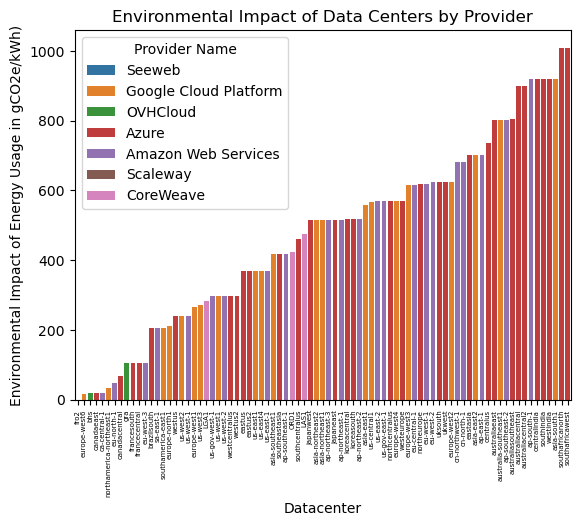

In [12]:
plt1 = sns.barplot(data = df, x = "region", y = "impact", hue = "providerName")
plt1.tick_params(axis='x', rotation=90, labelsize = 5)
plt1.set_title("Environmental Impact of Data Centers by Provider")
plt1.set_ylabel("Environmental Impact of Energy Usage in gCO2e/kWh)")
plt1.set_xlabel("Datacenter")
plt1.legend(title = "Provider Name", loc = "best")

We realise that the Cloud provider has less of an impact on environmental costs than the country where the datacenter is located.

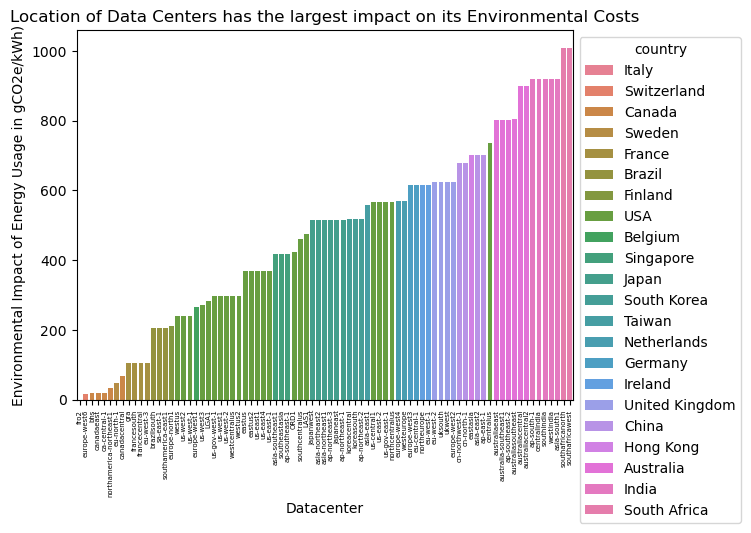

In [13]:
plt2 = sns.barplot(data = df, x = "region", y = "impact", hue = "country")
plt2.tick_params(axis='x', rotation=90, labelsize = 5)
plt2.set_title("Location of Data Centers has the largest impact on its Environmental Costs")
plt2.set_ylabel("Environmental Impact of Energy Usage in gCO2e/kWh)")
plt2.set_xlabel("Datacenter")
# plt.legend(title = "Provider Name", loc = "best")
sns.move_legend(plt2, "upper left", bbox_to_anchor=(1, 1))

We now look at the energy efficieny of hardware choices

In [14]:
df_gpus = pd.read_csv("./gpus.csv")

In [15]:
df_gpus["GFLOPS32/W"].isna().count()

45

In [16]:
df_gpus["GFLOPS16/W"].isna().count()

45

In [17]:
df_gpus=df_gpus[df_gpus["GFLOPS32/W"].notna()]

In [65]:
# df_gpus.head()

In [18]:
df_gpus.sort_values(by = ["GFLOPS32/W"], inplace = True, ascending = False)

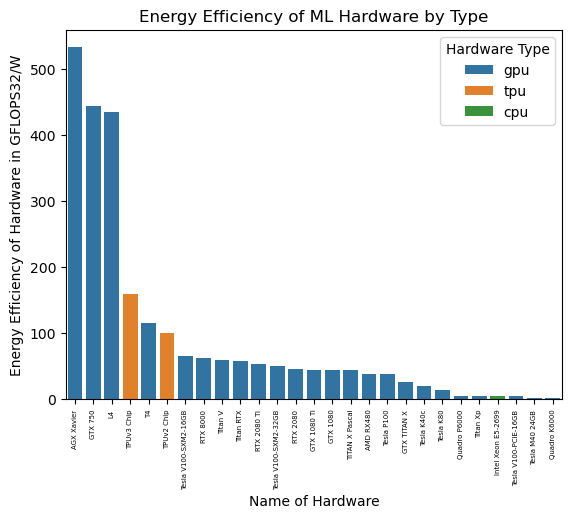

In [19]:
plt3 = sns.barplot(data = df_gpus, x = "name", y = "GFLOPS32/W", hue = "type")
plt3.tick_params(axis='x', rotation=90, labelsize = 5)
plt3.set_title("Energy Efficiency of ML Hardware by Type")
plt3.set_ylabel("Energy Efficiency of Hardware in GFLOPS32/W")
plt3.set_xlabel("Name of Hardware")
plt3.legend(title = "Hardware Type", loc = "best")

## Modeling

### Model 1: PCA clustering model with core.csv

In [20]:
df = pd.read_csv('parat_data_20240717/core.csv')

finance = df[df['Sector'] == 'Banking & Investment Services']
finance = finance[['Name', 
                   'Patents: AI use cases: Banking and finance']].join(finance.filter(regex='^Publications'))
finance = finance[finance['Name'] != 'First Republic Bank']

In [21]:
df_chatbot = pd.read_csv('finance_chatbot_use.csv')
with open('custom_bank_ai.csv', 'r', encoding='utf-8', errors='ignore') as f:
    df_ai = pd.read_csv(f)

data = finance.merge(df_chatbot, left_on='Name', right_on='name', how='left')

In [22]:
data['Publications: Recent AI publication growth'] = data['Publications: Recent AI publication growth'].fillna(0)

In [24]:
# Select only numerical columns for PCA
numerical_data = data.select_dtypes(include=[float, int])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)
# Initialize PCA (for example, to reduce to 2 components)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

"""# Display the resulting principal components
print(pca_df.head())


"""
print(pca.explained_variance_ratio_)

[0.54566388 0.15855204]


In [25]:

# Encode the target column 'consumer_facing' to binary values
le = LabelEncoder()
data['consumer_facing_binary'] = le.fit_transform(data['customer_facing'])  # 1 for "Yes", 0 for "No"

# Add the target to the PCA data
pca_df['consumer_facing'] = data['consumer_facing_binary']
X = pca_df[['PC1', 'PC2']]
y = pca_df['consumer_facing']

"""# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)"""

# Fit Logistic Regression model
model = LogisticRegression()
model.fit(X, y)


"""y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))"""

'y_pred = model.predict(X_test)\nprint("Accuracy:", accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred, target_names=le.classes_))'

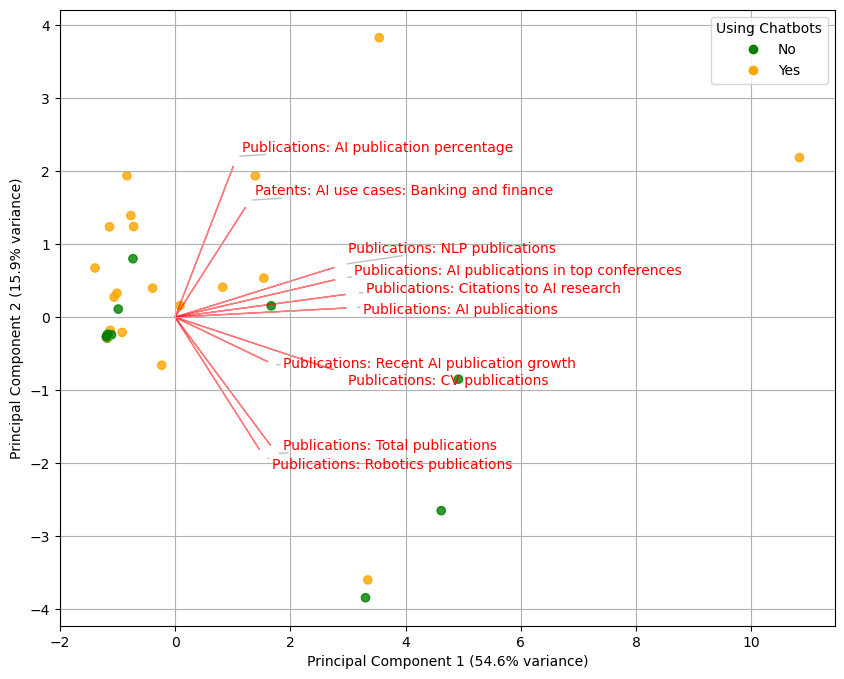

In [26]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(10, 8))
cmap = ListedColormap(['green', 'orange'])
scatter = plt.scatter(X['PC1'], X['PC2'], c=y, cmap=cmap, alpha=0.8)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='No'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Yes')
], title="Using Chatbots")

# Plot arrows for each variable's loading on the principal components
texts = []
for i, var in enumerate(numerical_data.columns):
    plt.arrow(0, 0, loadings[i, 0] * 3, loadings[i, 1] * 3, color='red', alpha=0.5)  # Scaling factor of 3 for visibility
    texts.append(plt.text(loadings[i, 0] * 3.2, loadings[i, 1] * 3.2, var, color='red', ha='left', va='center'))

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Set plot labels and title
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('')
plt.grid()
plt.gca().patch.set_alpha(0.0)
plt.show()

### Model 2: Predicting Carbon Emissioin

In this section, we investigate the provided data, and make prediction on the carbon emission of the language models.

In [27]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

We first pick the quantitative features that contribute to carbon emission of each model, handled missing values in the "large_scale_ai_models_added_cols.csv" file, and then used models to predict.

In [28]:
df0 = pd.read_csv("large_scale_ai_models_added_cols.csv")

In [29]:
columns = ["System", "Domain", "Task", "Organization", "Parameters", "Training compute (FLOP)",
           "Training dataset size (datapoints)", "Hardware quantity", "Training power (Watts) ",
           "Training energy (kWh) ", "Carbon Emissions from training (lb)"]

In [30]:
df1 = df0[columns]
df1["Training power (Watts) "] = df1["Training power (Watts) "].astype(float)
df1["Training energy (kWh) "] = df1["Training energy (kWh) "].astype(float)
df1["Carbon Emissions from training (lb)"] = df1["Carbon Emissions from training (lb)"].astype(float)

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\208735848.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\208735848.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\208735848.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Some models take on various tasks. We pivot the column to each name of the task to better assess each model, and gather more data points.

In [31]:
df1['Task'] = df1['Task'].str.replace('\n', '').str.strip()
df_exploded = df1.assign(Task=df1['Task'].str.split(',')).explode('Task')

df_exploded['Task'] = df_exploded['Task'].str.strip()

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\223903819.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
df_exploded.groupby("Task")["Carbon Emissions from training (lb)"].count().sort_values(ascending=False)

Task
Language modelling/generation                     15
Language modelling                                10
Chat                                               6
Translation                                        5
Question answering                                 4
Code generation                                    4
Visual question answering                          3
Text-to-image                                      3
Vision-language generation                         2
Go                                                 2
Text autocompletion                                2
Audio generation                                   1
Image generation                                   1
Language generation                                1
Semantic search                                    1
Text summarization                                 1
Video generation                                   1
Text classification                                0
Table tasks                              

Notice there are many missing values of the quantitative variables, we impute the missing places with the mean of available values.

In [33]:
df_exploded["Parameters"].fillna(df_exploded["Parameters"].mean(), inplace=True)
df_exploded["Training compute (FLOP)"].fillna(df_exploded["Training compute (FLOP)"].mean(), inplace=True)
df_exploded["Training dataset size (datapoints)"].fillna(df_exploded["Training dataset size (datapoints)"].mean(), inplace=True)
df_exploded["Hardware quantity"].fillna(df_exploded["Hardware quantity"].mean(), inplace=True)
df_exploded["Training power (Watts) "].fillna(0, inplace=True)
pd.set_option('display.float_format', '{:.6f}'.format)

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\2570745567.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\23502\AppData\Local\Temp\ipykernel_1248\2570745567.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [34]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)

In [35]:
df3.shape

(62, 11)

In [37]:
# df3

#### After data cleaning and preparation, we move on to prediction with various models.

First, we use Ridge Regression. The data have potential multicolinearity problem, and we want to control overfitting of the model. We want to start by using a linear regression to try capturing the effect.

In [38]:
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

loo = LeaveOneOut()

model = Ridge(alpha=1.0) 

model.fit(X, y)
train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")
scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_absolute_error')

mean_mae = -np.mean(scores)

print(f"Mean Absolute Error (LOOCV): {mean_mae}")


Training MSE: 17.890144767299777
Training RMSE: 4.229674309837552
Training R²: 1.0
Mean Absolute Error (LOOCV): 18.42978988155242


c:\Users\23502\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=8.52762e-43): result may not be accurate.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=8.51126e-43): result may not be accurate.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=8.55839e-43): result may not be accurate.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=8.55839e-43): result may not be accurate.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: L

The second method we're using is neural network. This is better for non-linear prediction. 

In [39]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X, y = X[non_outlier_mask], y[non_outlier_mask]

test = df_exploded[~df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
test_X = test.drop(columns=["System", "Domain", "Task", "Organization"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 500],
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 5, 7]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

model.fit(X, y)
train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

test_X = test_X.reindex(columns=X.columns, fill_value=0)
test_X = grid.best_estimator_.named_steps['imputer'].transform(test_X)
test_X = grid.best_estimator_.named_steps['scaler'].transform(test_X)
predictions = grid.best_estimator_.named_steps['model'].predict(test_X)

test['Carbon Emissions from training (lb)'] = predictions
df_combined = pd.concat([df3, test], ignore_index=True)


Training MSE: 0.006317223821367536
Training RMSE: 0.07948096515120798
Training R²: 1.0


c:\Users\23502\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Biulding on from the neural net model which yeilds an overfitting problem, we fit the data again using XGBoost model. This is a non-linear tree-based model and better to mitigate overfitting problem.

In [40]:
df3 = df_exploded[df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
target_column = "Carbon Emissions from training (lb)"
X = df3.drop(columns=["System", "Domain", "Task", "Organization"])
y = df3[target_column]

q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X, y = X[non_outlier_mask], y[non_outlier_mask]

test = df_exploded[~df_exploded["Carbon Emissions from training (lb)"].notnull()].reset_index(drop=True)
test_X = test.drop(columns=["System", "Domain", "Task", "Organization"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=500))
])

param_grid = {
    'model__hidden_layer_sizes': [(100,), (100, 100), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__alpha': [0.0001, 0.001]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

model = grid.best_estimator_

train_predictions = model.predict(X)

mse = mean_squared_error(y, train_predictions)
rmse = mean_squared_error(y, train_predictions, squared=False)
r2 = r2_score(y, train_predictions)

print(f"Training MSE: {mse}")
print(f"Training RMSE: {rmse}")
print(f"Training R²: {r2}")

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Opt

Training MSE: 1.4634195237675376e+27
Training RMSE: 38254666692673.42
Training R²: 0.7334105706206746


c:\Users\23502\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



#### Plotting predicted carbon emission

Comparing the three models, we decide to use XGBoost for further analysis. Ridge Regression is better used for linear or slightly non-linear problems where interpretability and simplicity are important. In our case, variables such as "training energy", "training power " are highly correlated with carbon emission. This means linear model might not be a good fit.
Neural Network model is ideal for highly non-linear, complex problems with abundant data and computational power. However, given the constraint of data (only 62 observations after processed), it would not be the best fit. XGBoost is a good choice for dealing with structured data with mixed types and yields excellent performance and scalability even with a higher training MSE compared to neural network model. Overall, we pick XGBoost for the analysis.

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\126819426.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\126819426.py:44: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\126819426.py:44: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\126819426.py:44: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\126819426.py:44: UserWarning:

The palette list has mor

<Figure size 1600x1000 with 0 Axes>

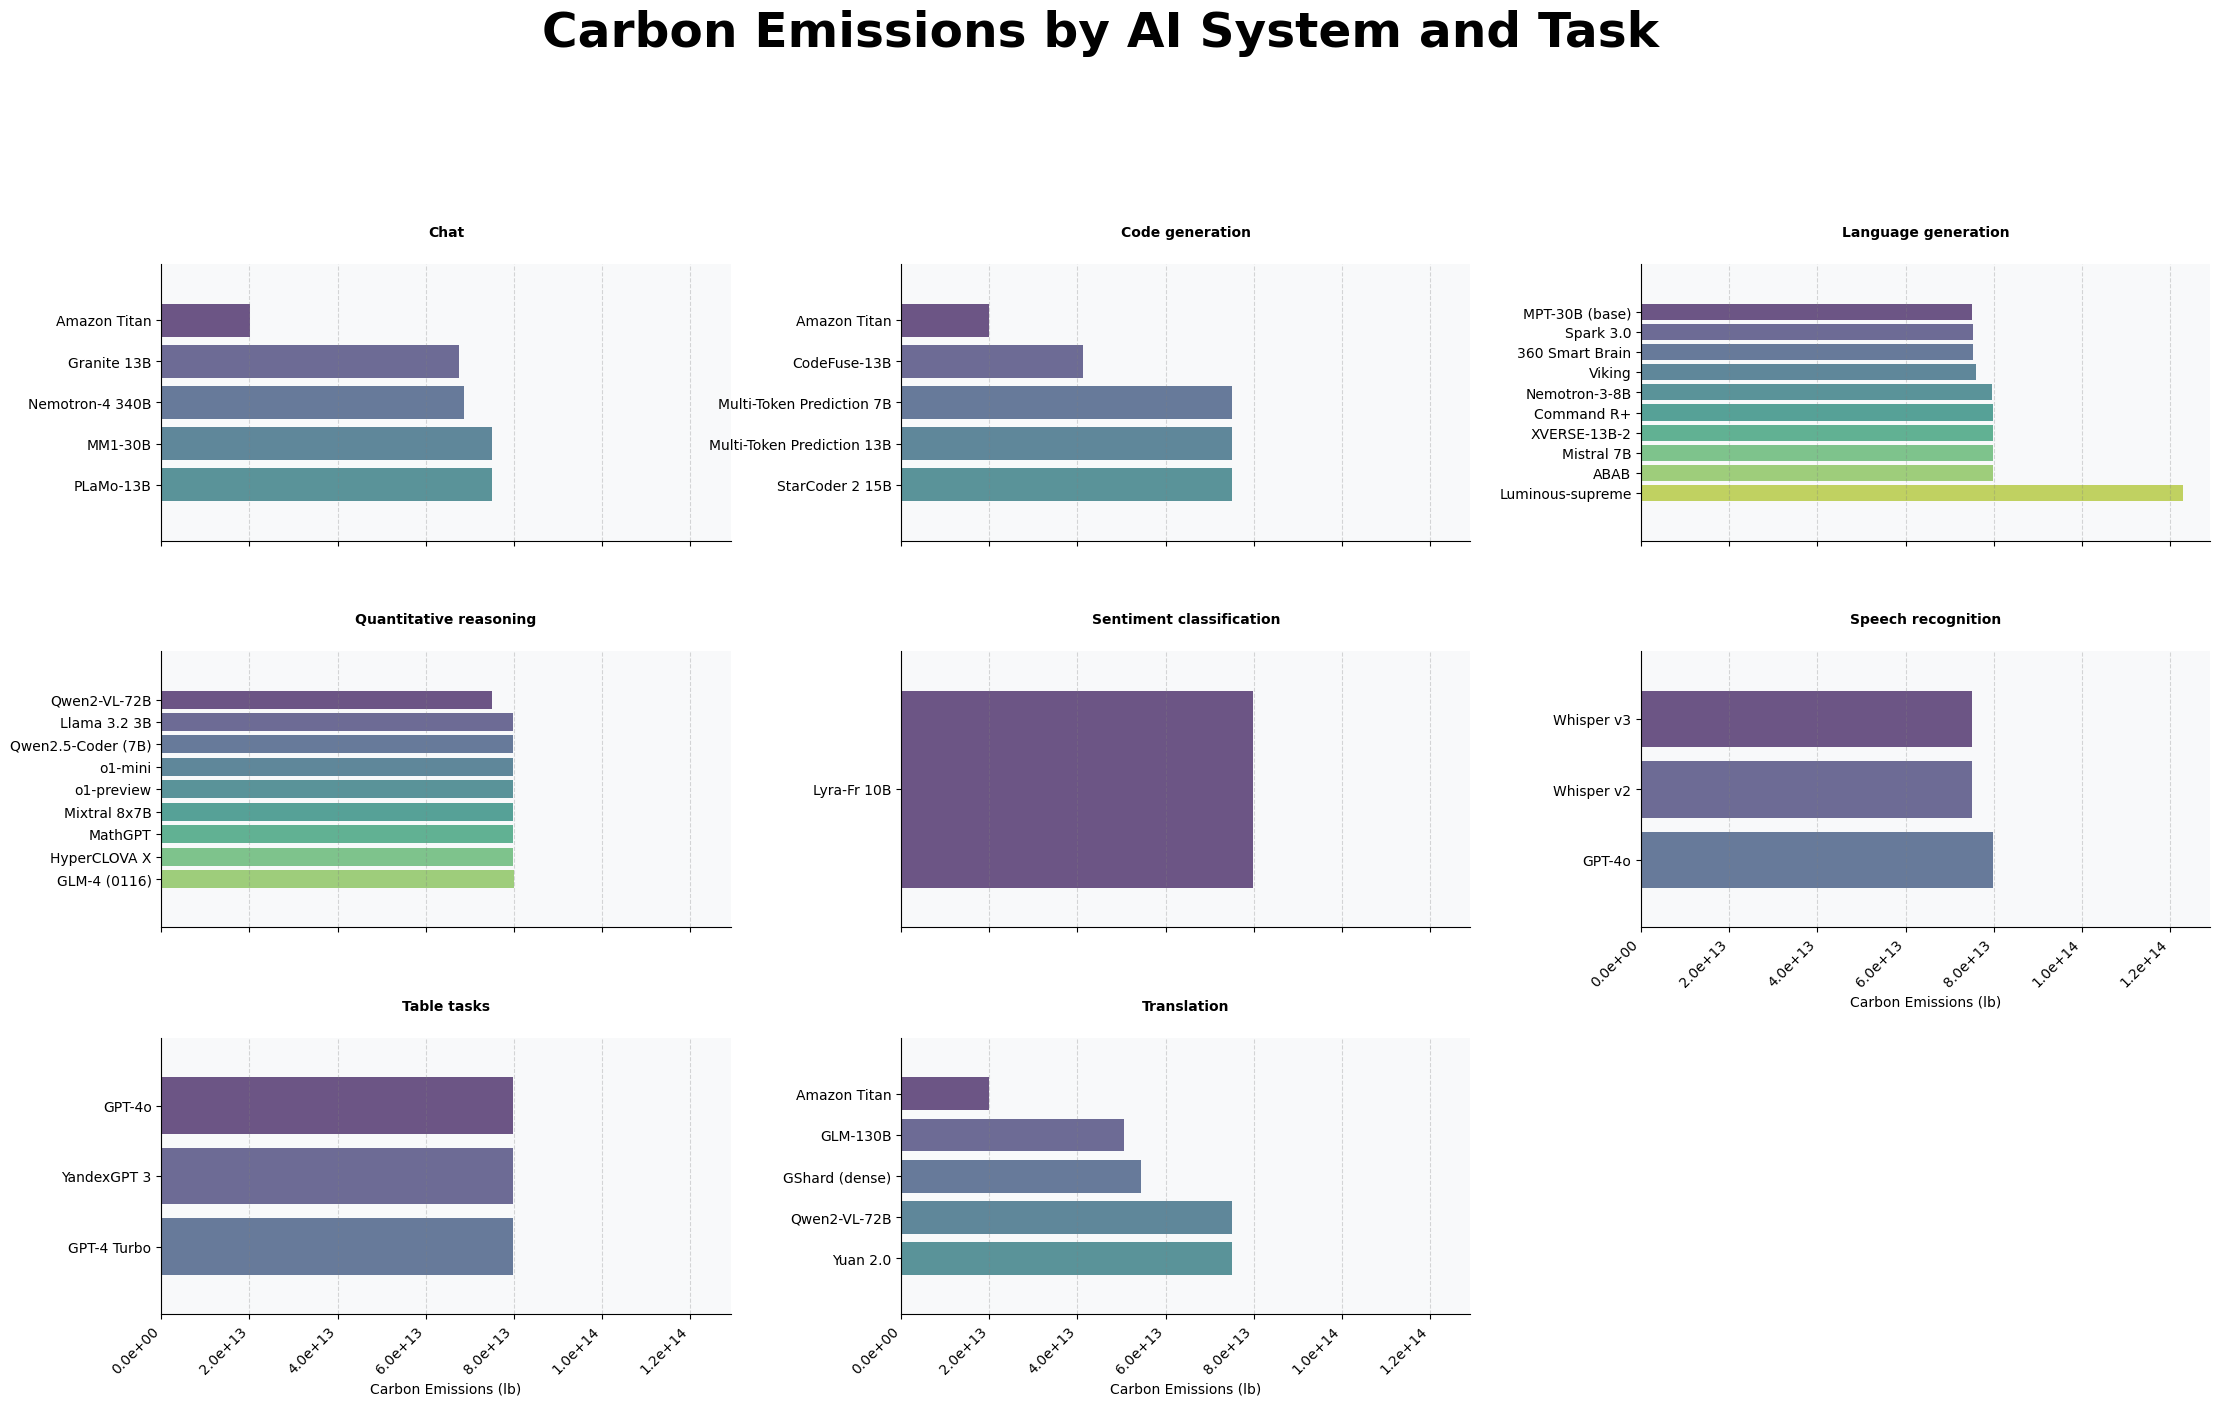

In [42]:
plt.style.use('default')
colors = sns.color_palette("viridis", n_colors=10)
sns.set_palette(colors)

df_combined_finance = df_combined[df_combined['Task'].isin([
    "Quantitative reasoning",
    "Sentiment classification", 
    "Code generation",
    "Speech recognition",
    "Translation",
    "Fraud detection",
    "Chat",
    "Language generation",
    "Table tasks"
])]

df_filtered = (
    df_combined_finance[df_combined_finance['Task'].isin(["Chat", "Code generation", "Translation"])]
    .groupby('Task', group_keys=False)
    .apply(lambda x: x.nsmallest(5, 'Carbon Emissions from training (lb)'))
)

df_remaining = df_combined_finance[~df_combined_finance['Task'].isin(["Chat", "Code generation", "Translation"])]

df_combined_filtered = pd.concat([df_filtered, df_remaining], ignore_index=True)

df_combined_filtered = df_combined_filtered.sort_values(
    ['Task', 'Carbon Emissions from training (lb)'],
    ascending=[True, True]
)

plt.figure(figsize=(16, 10))
g = sns.FacetGrid(
    df_combined_filtered,
    col="Task",
    sharey=False,
    sharex=True,
    height=5,
    col_wrap=3,
    aspect=1.5
)

def custom_barplot(*args, **kwargs):
    ax = sns.barplot(*args, **kwargs, 
                    order=kwargs['data'].sort_values('Carbon Emissions from training (lb)')['System'],
                    palette=colors)
    for patch in ax.patches:
        patch.set_alpha(0.8)

g.map_dataframe(
    custom_barplot,
    x="Carbon Emissions from training (lb)",
    y="System",
    hue="System",
    dodge=False
)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1e}"))
    ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
    plt.setp(ax.patches, linewidth=1)
    ax.margins(y=0.2)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax.set_facecolor('#f8f9fa')

g.set_titles("{col_name}", pad=20, fontsize=30, fontweight='bold')
g.set_axis_labels("Carbon Emissions (lb)", "")
g.fig.suptitle(
    "Carbon Emissions by AI System and Task",
    y=1.02,
    fontsize=35,
    fontweight='bold'
)

g.fig.subplots_adjust(
    top=0.85,
    bottom=0.15,
    wspace=0.3,
    hspace=0.4
)

g.fig.patch.set_facecolor('#ffffff')

plt.show()

## PCA/TSNE Analysis and Clustering

Obtained data from CSET's Private-sector AI Relatred Activity tracker, https://github.com/georgetown-cset/parat
Also collected our own data for chatbot usage by finance firms in finance_chatbot_use.csv
This data is useful as a proxy for AI activity within the financial firms, since model training and fine-tuning, part of the research and development phase of AI models, utilise the most energy and are a good proxy for AI activity. Furthermore, most data in this area is not public, and it is difficult to obtain information about internal-facing AI models finance companies are using, hence we decide to look at only the customer-facing chatbot function.

In [43]:
df = pd.read_csv("core.csv")
df_chatbot = pd.read_csv("./finance_chatbot_use.csv")

In [44]:
df_chatbot.head()
# df.head()

,name,use_chatbot,customer_facing
0,Wells Fargo,Yes,Yes
1,Citi,No,No
2,Bank of America,Yes,Yes
3,Capital One,Yes,Yes
4,Morgan Stanley,Yes,No


In [45]:
df.Sector.unique()

array(['Software & IT Services', 'Retailers',
       'Industrial & Commercial Services', 'Technology Equipment',
       'Unknown', 'Banking & Investment Services',
       'Telecommunications Services', 'Industrial Goods',
       'Financial Technology (Fintech) & Infrastructure',
       'Healthcare Services & Equipment', 'Automobiles & Auto Parts',
       'Consumer Goods Conglomerates', 'Food & Drug Retailing',
       'Pharmaceuticals & Medical Research', 'Cyclical Consumer Services',
       'Cyclical Consumer Products', 'Transportation',
       'Energy - Fossil Fuels', 'Food & Beverages',
       'Personal & Household Products & Services', 'Insurance',
       'Real Estate', 'Mineral Resources', 'Utilities', 'Chemicals',
       'Applied Resources'], dtype=object)

We will only consider the companies in the Banking & Investment Services sector.

In [46]:
X = df[df.Sector == 'Banking & Investment Services']
# X.isnull().sum()
# X.head()

We delete some irrelevant rows

In [47]:
X.drop(['Name', 'ID', 'Country', 'Website', 'Groups', 'Aggregated subsidiaries',
       'Region', 'Stage', 'Sector', 'Description', 'Description source',
       'Description link', 'Description date', 'Publications: CV publications', 'Publications: NLP publications',
       'Publications: Robotics publications',
       'Publications: Total publications','Patents: AI use cases: Agriculture',
       'Patents: AI use cases: Computing in government',
       'Patents: AI use cases: Education', 'Patents: AI use cases: Energy',
       'Patents: AI use cases: Entertainment',
       'Patents: AI use cases: Industry and manufacturing',
       'Patents: AI use cases: Life sciences',
       'Patents: AI use cases: Military',
       'Patents: AI use cases: Nanotechnology',
       'Patents: AI use cases: Networking',
       'Patents: AI use cases: Personal devices and computing','PARAT link',
       ], axis=1, inplace=True)

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\1184871233.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
X.drop(['Publications: Recent AI publication growth','Patents: AI patents: recent growth',
       'Patents: AI use cases: Physical sciences and engineering',
       'Patents: AI use cases: Security',
       'Patents: AI use cases: Semiconductors',
       'Patents: AI use cases: Telecommunications',
       'Patents: AI use cases: Transportation','Patents: AI applications and techniques: Robotics',
       'Patents: AI applications and techniques: Speech processing',
       'City',
       'State/province'
       ], axis=1, inplace=True)

C:\Users\23502\AppData\Local\Temp\ipykernel_1248\1004078433.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We will try to scale the data to conduct EDA

In [49]:
X = pd.get_dummies(X)

In [50]:
numer = X[['Publications: AI publications',
       'Publications: AI publication percentage',
       'Publications: AI publications in top conferences',
       'Publications: Citations to AI research', 'Patents: AI patents',
       'Patents: AI patent percentage', 'Patents: Granted AI patents',
       'Patents: Total patents', 'Patents: AI use cases: Banking and finance',
       'Patents: AI use cases: Business',
       'Patents: AI use cases: Document management and publishing',
       'Patents: AI applications and techniques: Analytics and algorithms',
       'Patents: AI applications and techniques: Computer vision',
       'Patents: AI applications and techniques: Control',
       'Patents: AI applications and techniques: Distributed AI',
       'Patents: AI applications and techniques: Knowledge representation',
       'Patents: AI applications and techniques: Language processing',
       'Patents: AI applications and techniques: Measuring and testing',
       'Patents: AI applications and techniques: Planning and scheduling',
       'Workforce: AI workers', 'Workforce: Tech Tier 1 workers']]

In [51]:
# numer.head()

In [52]:
scaler = StandardScaler()

In [53]:
numer = pd.DataFrame(scaler.fit_transform(numer))

In [54]:
numer.columns = ['Publications: AI publications',
       'Publications: AI publication percentage',
       'Publications: AI publications in top conferences',
       'Publications: Citations to AI research', 'Patents: AI patents',
       'Patents: AI patent percentage', 'Patents: Granted AI patents',
       'Patents: Total patents', 'Patents: AI use cases: Banking and finance',
       'Patents: AI use cases: Business',
       'Patents: AI use cases: Document management and publishing',
       'Patents: AI applications and techniques: Analytics and algorithms',
       'Patents: AI applications and techniques: Computer vision',
       'Patents: AI applications and techniques: Control',
       'Patents: AI applications and techniques: Distributed AI',
       'Patents: AI applications and techniques: Knowledge representation',
       'Patents: AI applications and techniques: Language processing',
       'Patents: AI applications and techniques: Measuring and testing',
       'Patents: AI applications and techniques: Planning and scheduling',
       'Workforce: AI workers', 'Workforce: Tech Tier 1 workers']

In [55]:
# X.head()

We decide to carry out KMeans clustering for visualisation

In [56]:
kmeans = KMeans(n_clusters=3)

In [57]:
kmeans.fit(X)

c:\Users\23502\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=3)

In [58]:
clusters = kmeans.predict(X)

In [59]:
#Add the cluster vector to our DataFrame, X
X["Cluster"] = clusters

In [60]:
#plotX is a DataFrame values from X
plotX = pd.DataFrame(np.array(X))

#Rename plotX's columns since it was briefly converted to an np.array above
plotX.columns = X.columns

In [61]:
#PCA with one principal component
pca_1d = PCA(n_components=1)

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)

In [62]:
#This DataFrame holds that single principal component mentioned above
PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three principal components that will aid us
#in visualizing our clusters in 3-D
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

In [63]:
PCs_1d.columns = ["PC1_1d"]

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [64]:
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
plotX["dummy"] = 0

In [65]:
#Note that all of the DataFrames below are sub-DataFrames of 'plotX'.
#This is because we intend to plot the values contained within each of these DataFrames.

cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]

In [66]:
#This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)

In [67]:
#Instructions for building the 1-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]
title = "Visualizing Clusters in One Dimension Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [68]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)

iplot(fig)

In [69]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

We will now use TSNE to visualise instead

In [70]:
#plotX will hold the values we wish to plot
plotX = pd.DataFrame(np.array(X))
plotX.columns = X.columns

In [71]:
perplexity = 8

In [72]:
#T-SNE with one dimension
tsne_1d = TSNE(n_components=1, perplexity=perplexity)

#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=perplexity)

#T-SNE with three dimensions
tsne_3d = TSNE(n_components=3, perplexity=perplexity)

In [73]:
#This DataFrame holds a single dimension,built by T-SNE
TCs_1d = pd.DataFrame(tsne_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains two dimensions, built by T-SNE
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three dimensions, built by T-SNE
TCs_3d = pd.DataFrame(tsne_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

In [74]:
TCs_1d.columns = ["TC1_1d"]

PCs_1d.columns = ["PC1_1d"]

#"TC1_2d" means: 'The first component of the components created for 2-D visualization, by T-SNE.'
#And "TC2_2d" means: 'The second component of the components created for 2-D visualization, by T-SNE.'
TCs_2d.columns = ["TC1_2d","TC2_2d"]

TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

In [75]:
plotX = pd.concat([plotX,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')


In [76]:
plotX["dummy"] = 0

In [77]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]

In [78]:
#Instructions for building the 1-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in One Dimension Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [79]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_2d"],
                    y = cluster0["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_2d"],
                    y = cluster1["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [81]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["TC1_3d"],
                    y = cluster0["TC2_3d"],
                    z = cluster0["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["TC1_3d"],
                    y = cluster1["TC2_3d"],
                    z = cluster1["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["TC1_3d"],
                    y = cluster2["TC2_3d"],
                    z = cluster2["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)
iplot(fig)


We observe a heatmap of the correlations between companies and the various indicies representing AI activity, we find that index 4, Salesforce, has a high correlation with most of the indicators

<Axes: >

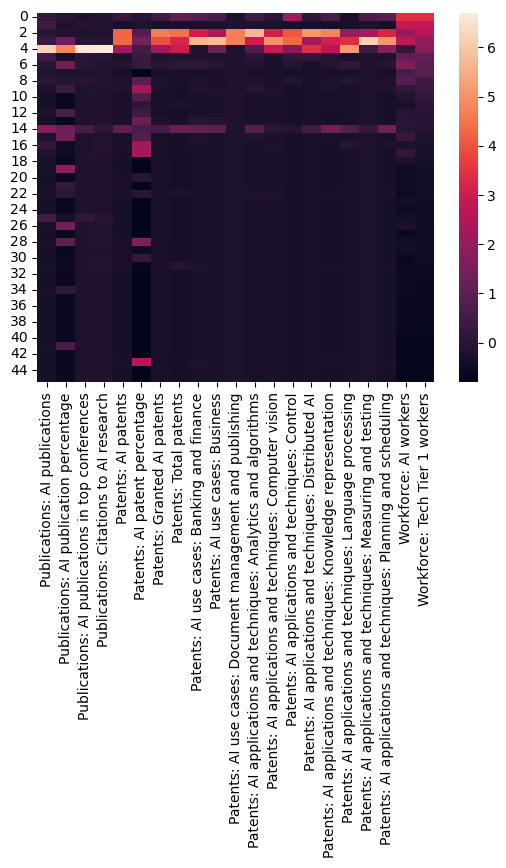

In [82]:
sns.heatmap(numer)

# Final Questions to be answered
In 10-20 years, AI is likely to become more integrated into industries, with significant advancements in energy-efficient models and infrastructure. As awareness of environmental impacts grows, companies may adopt stricter sustainability guidelines, favoring innovations in low-energy AI systems.

Our recommendations based on the entire analysis are: First, prioritize energy-efficient models for lighter tasks, while carefully weighing resource-intensive applications. Second, choose cloud providers that use low-carbon energy. Lastly, select energy-efficient GPU hardware. By making thoughtful choices in these areas, firms can better align AI operations with sustainability goals.
